# Lie Groups and SO(3): The Mathematics of Three-Dimensional Rotations

## 1. Introduction

The Special Orthogonal Group in three dimensions, denoted $\mathrm{SO}(3)$, is a fundamental mathematical structure that describes all possible rotations in three-dimensional Euclidean space. As a **Lie group**, $\mathrm{SO}(3)$ possesses both the structure of a smooth manifold and a group, making it an essential object of study in physics, robotics, computer graphics, and pure mathematics.

### 1.1 Definition of SO(3)

The group $\mathrm{SO}(3)$ consists of all $3 \times 3$ real matrices $R$ satisfying:

$$R^T R = R R^T = I \quad \text{(orthogonality)}$$

$$\det(R) = +1 \quad \text{(proper rotation, preserves orientation)}$$

where $I$ is the $3 \times 3$ identity matrix. The condition $\det(R) = +1$ distinguishes rotations from reflections (which have $\det(R) = -1$).

### 1.2 The Lie Algebra $\mathfrak{so}(3)$

Associated with every Lie group is its **Lie algebra**, which captures the infinitesimal structure of the group near the identity. For $\mathrm{SO}(3)$, the Lie algebra $\mathfrak{so}(3)$ consists of all $3 \times 3$ real skew-symmetric matrices:

$$\mathfrak{so}(3) = \{\Omega \in \mathbb{R}^{3 \times 3} : \Omega^T = -\Omega\}$$

Any element of $\mathfrak{so}(3)$ can be written as:

$$\Omega = \begin{pmatrix} 0 & -\omega_3 & \omega_2 \\ \omega_3 & 0 & -\omega_1 \\ -\omega_2 & \omega_1 & 0 \end{pmatrix} = [\boldsymbol{\omega}]_\times$$

where $\boldsymbol{\omega} = (\omega_1, \omega_2, \omega_3)^T \in \mathbb{R}^3$ is the **angular velocity vector**, and $[\cdot]_\times$ denotes the skew-symmetric (hat) map.

### 1.3 The Exponential Map

The **exponential map** $\exp: \mathfrak{so}(3) \to \mathrm{SO}(3)$ connects the Lie algebra to the Lie group:

$$R = \exp(\Omega) = \sum_{k=0}^{\infty} \frac{\Omega^k}{k!}$$

For $\mathrm{SO}(3)$, this has the closed-form expression known as **Rodrigues' rotation formula**:

$$\exp([\boldsymbol{\omega}]_\times) = I + \frac{\sin\theta}{\theta}[\boldsymbol{\omega}]_\times + \frac{1 - \cos\theta}{\theta^2}[\boldsymbol{\omega}]_\times^2$$

where $\theta = \|\boldsymbol{\omega}\|$ is the rotation angle about the axis $\hat{\boldsymbol{\omega}} = \boldsymbol{\omega}/\theta$.

### 1.4 Generators and the Lie Bracket

The Lie algebra $\mathfrak{so}(3)$ has three basis elements (generators):

$$L_x = \begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{pmatrix}, \quad
L_y = \begin{pmatrix} 0 & 0 & 1 \\ 0 & 0 & 0 \\ -1 & 0 & 0 \end{pmatrix}, \quad
L_z = \begin{pmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}$$

These satisfy the **commutation relations** (Lie bracket):

$$[L_i, L_j] = L_i L_j - L_j L_i = \epsilon_{ijk} L_k$$

where $\epsilon_{ijk}$ is the Levi-Civita symbol. This non-commutativity reflects the fact that 3D rotations do not commute in general.

## 2. Implementation

We now implement the key mathematical structures of $\mathrm{SO}(3)$ and demonstrate their properties computationally.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm, logm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully.")

Libraries loaded successfully.


### 2.1 The Skew-Symmetric (Hat) Map

We implement the isomorphism between $\mathbb{R}^3$ and $\mathfrak{so}(3)$.

In [2]:
def hat(omega):
    """
    Skew-symmetric (hat) map: R^3 -> so(3)
    Maps a 3D vector to its corresponding skew-symmetric matrix.
    
    Parameters:
    -----------
    omega : array-like, shape (3,)
        Angular velocity vector
    
    Returns:
    --------
    Omega : ndarray, shape (3, 3)
        Skew-symmetric matrix such that Omega @ v = omega x v
    """
    omega = np.asarray(omega).flatten()
    return np.array([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])

def vee(Omega):
    """
    Vee map: so(3) -> R^3
    Inverse of the hat map.
    
    Parameters:
    -----------
    Omega : ndarray, shape (3, 3)
        Skew-symmetric matrix
    
    Returns:
    --------
    omega : ndarray, shape (3,)
        Angular velocity vector
    """
    return np.array([Omega[2, 1], Omega[0, 2], Omega[1, 0]])

# Demonstrate the hat map
omega = np.array([1.0, 2.0, 3.0])
Omega = hat(omega)

print("Angular velocity vector ω:")
print(omega)
print("\nSkew-symmetric matrix [ω]×:")
print(Omega)
print("\nVerify skew-symmetry (Ω + Ω^T = 0):")
print(Omega + Omega.T)
print("\nVerify vee(hat(ω)) = ω:")
print(vee(Omega))

Angular velocity vector ω:
[1. 2. 3.]

Skew-symmetric matrix [ω]×:
[[ 0. -3.  2.]
 [ 3.  0. -1.]
 [-2.  1.  0.]]

Verify skew-symmetry (Ω + Ω^T = 0):
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Verify vee(hat(ω)) = ω:
[1. 2. 3.]


### 2.2 Rodrigues' Rotation Formula

We implement the exponential map from $\mathfrak{so}(3)$ to $\mathrm{SO}(3)$ using the closed-form Rodrigues' formula.

In [3]:
def rodrigues(omega):
    """
    Rodrigues' rotation formula: exp([ω]×) -> SO(3)
    Computes the rotation matrix from an axis-angle representation.
    
    Parameters:
    -----------
    omega : array-like, shape (3,)
        Rotation vector (axis * angle)
    
    Returns:
    --------
    R : ndarray, shape (3, 3)
        Rotation matrix in SO(3)
    """
    omega = np.asarray(omega).flatten()
    theta = np.linalg.norm(omega)
    
    if theta < 1e-10:
        # First-order approximation for small angles
        return np.eye(3) + hat(omega)
    
    Omega = hat(omega)
    # Rodrigues' formula
    R = np.eye(3) + (np.sin(theta) / theta) * Omega + \
        ((1 - np.cos(theta)) / theta**2) * (Omega @ Omega)
    return R

def log_so3(R):
    """
    Logarithm map: SO(3) -> so(3)
    Computes the rotation vector from a rotation matrix.
    
    Parameters:
    -----------
    R : ndarray, shape (3, 3)
        Rotation matrix
    
    Returns:
    --------
    omega : ndarray, shape (3,)
        Rotation vector
    """
    theta = np.arccos(np.clip((np.trace(R) - 1) / 2, -1, 1))
    
    if theta < 1e-10:
        return np.zeros(3)
    elif np.abs(theta - np.pi) < 1e-10:
        # Handle the π rotation case
        # Find the column with the largest diagonal element
        i = np.argmax(np.diag(R))
        v = R[:, i] + np.eye(3)[:, i]
        v = v / np.linalg.norm(v)
        return np.pi * v
    else:
        Omega = (theta / (2 * np.sin(theta))) * (R - R.T)
        return vee(Omega)

# Demonstrate Rodrigues' formula
# Rotation of π/3 about the z-axis
angle = np.pi / 3
axis = np.array([0, 0, 1])
omega = angle * axis

R = rodrigues(omega)
print(f"Rotation by {np.degrees(angle):.1f}° about z-axis:")
print("\nRotation matrix R:")
print(R)
print(f"\nVerify R^T R = I (orthogonality):")
print(R.T @ R)
print(f"\nVerify det(R) = +1: {np.linalg.det(R):.10f}")

# Compare with scipy's matrix exponential
R_scipy = expm(hat(omega))
print(f"\nMax difference from scipy.linalg.expm: {np.max(np.abs(R - R_scipy)):.2e}")

Rotation by 60.0° about z-axis:

Rotation matrix R:
[[ 0.5       -0.8660254  0.       ]
 [ 0.8660254  0.5        0.       ]
 [ 0.         0.         1.       ]]

Verify R^T R = I (orthogonality):
[[ 1.00000000e+00 -1.48741681e-17  0.00000000e+00]
 [-1.48741681e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Verify det(R) = +1: 1.0000000000

Max difference from scipy.linalg.expm: 1.11e-16


### 2.3 Lie Algebra Generators and Commutation Relations

In [4]:
# Define the generators of so(3)
L_x = hat([1, 0, 0])  # Generator for rotations about x-axis
L_y = hat([0, 1, 0])  # Generator for rotations about y-axis
L_z = hat([0, 0, 1])  # Generator for rotations about z-axis

generators = {'L_x': L_x, 'L_y': L_y, 'L_z': L_z}

print("Generators of so(3):")
for name, L in generators.items():
    print(f"\n{name}:")
    print(L)

def lie_bracket(A, B):
    """Compute the Lie bracket [A, B] = AB - BA"""
    return A @ B - B @ A

# Verify commutation relations
print("\n" + "="*50)
print("Verification of Commutation Relations:")
print("="*50)

print("\n[L_x, L_y] = L_z:")
comm_xy = lie_bracket(L_x, L_y)
print(f"[L_x, L_y] =\n{comm_xy}")
print(f"L_z =\n{L_z}")
print(f"Match: {np.allclose(comm_xy, L_z)}")

print("\n[L_y, L_z] = L_x:")
comm_yz = lie_bracket(L_y, L_z)
print(f"Match: {np.allclose(comm_yz, L_x)}")

print("\n[L_z, L_x] = L_y:")
comm_zx = lie_bracket(L_z, L_x)
print(f"Match: {np.allclose(comm_zx, L_y)}")

Generators of so(3):

L_x:
[[ 0  0  0]
 [ 0  0 -1]
 [ 0  1  0]]

L_y:
[[ 0  0  1]
 [ 0  0  0]
 [-1  0  0]]

L_z:
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  0]]

Verification of Commutation Relations:

[L_x, L_y] = L_z:
[L_x, L_y] =
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  0]]
L_z =
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  0]]
Match: True

[L_y, L_z] = L_x:
Match: True

[L_z, L_x] = L_y:
Match: True


### 2.4 Non-Commutativity of Rotations

One of the fundamental properties of $\mathrm{SO}(3)$ is that rotations do not commute in general: $R_1 R_2 \neq R_2 R_1$.

In [5]:
# Demonstrate non-commutativity
angle = np.pi / 2  # 90 degrees

R_x = rodrigues(angle * np.array([1, 0, 0]))  # 90° about x-axis
R_y = rodrigues(angle * np.array([0, 1, 0]))  # 90° about y-axis

# Apply rotations in different orders
R_xy = R_y @ R_x  # First x, then y
R_yx = R_x @ R_y  # First y, then x

print("R_x (90° about x):")
print(np.round(R_x, 4))
print("\nR_y (90° about y):")
print(np.round(R_y, 4))
print("\nR_y @ R_x (first x, then y):")
print(np.round(R_xy, 4))
print("\nR_x @ R_y (first y, then x):")
print(np.round(R_yx, 4))
print(f"\nAre they equal? {np.allclose(R_xy, R_yx)}")
print(f"Frobenius norm of difference: {np.linalg.norm(R_xy - R_yx):.4f}")

R_x (90° about x):
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]

R_y (90° about y):
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]

R_y @ R_x (first x, then y):
[[ 0.  1.  0.]
 [ 0.  0. -1.]
 [-1.  0.  0.]]

R_x @ R_y (first y, then x):
[[ 0.  0.  1.]
 [ 1.  0. -0.]
 [-0.  1.  0.]]

Are they equal? False
Frobenius norm of difference: 2.4495


## 3. Visualization

We create visualizations to illustrate the geometric meaning of SO(3) rotations.

In [6]:
class Arrow3D(FancyArrowPatch):
    """Custom 3D arrow for matplotlib"""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

def draw_coordinate_frame(ax, R, origin=np.zeros(3), scale=1.0, alpha=1.0, label_prefix=''):
    """
    Draw a rotated coordinate frame.
    
    Parameters:
    -----------
    ax : Axes3D
        Matplotlib 3D axes
    R : ndarray, shape (3, 3)
        Rotation matrix
    origin : ndarray, shape (3,)
        Origin of the coordinate frame
    scale : float
        Length of the axes
    alpha : float
        Transparency
    label_prefix : str
        Prefix for axis labels
    """
    colors = ['r', 'g', 'b']
    labels = ['x', 'y', 'z']
    
    for i in range(3):
        direction = R[:, i] * scale
        ax.quiver(origin[0], origin[1], origin[2],
                  direction[0], direction[1], direction[2],
                  color=colors[i], alpha=alpha, arrow_length_ratio=0.1,
                  linewidth=2)

def create_sphere_points(n_points=50):
    """Generate points on a unit sphere"""
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    return x, y, z

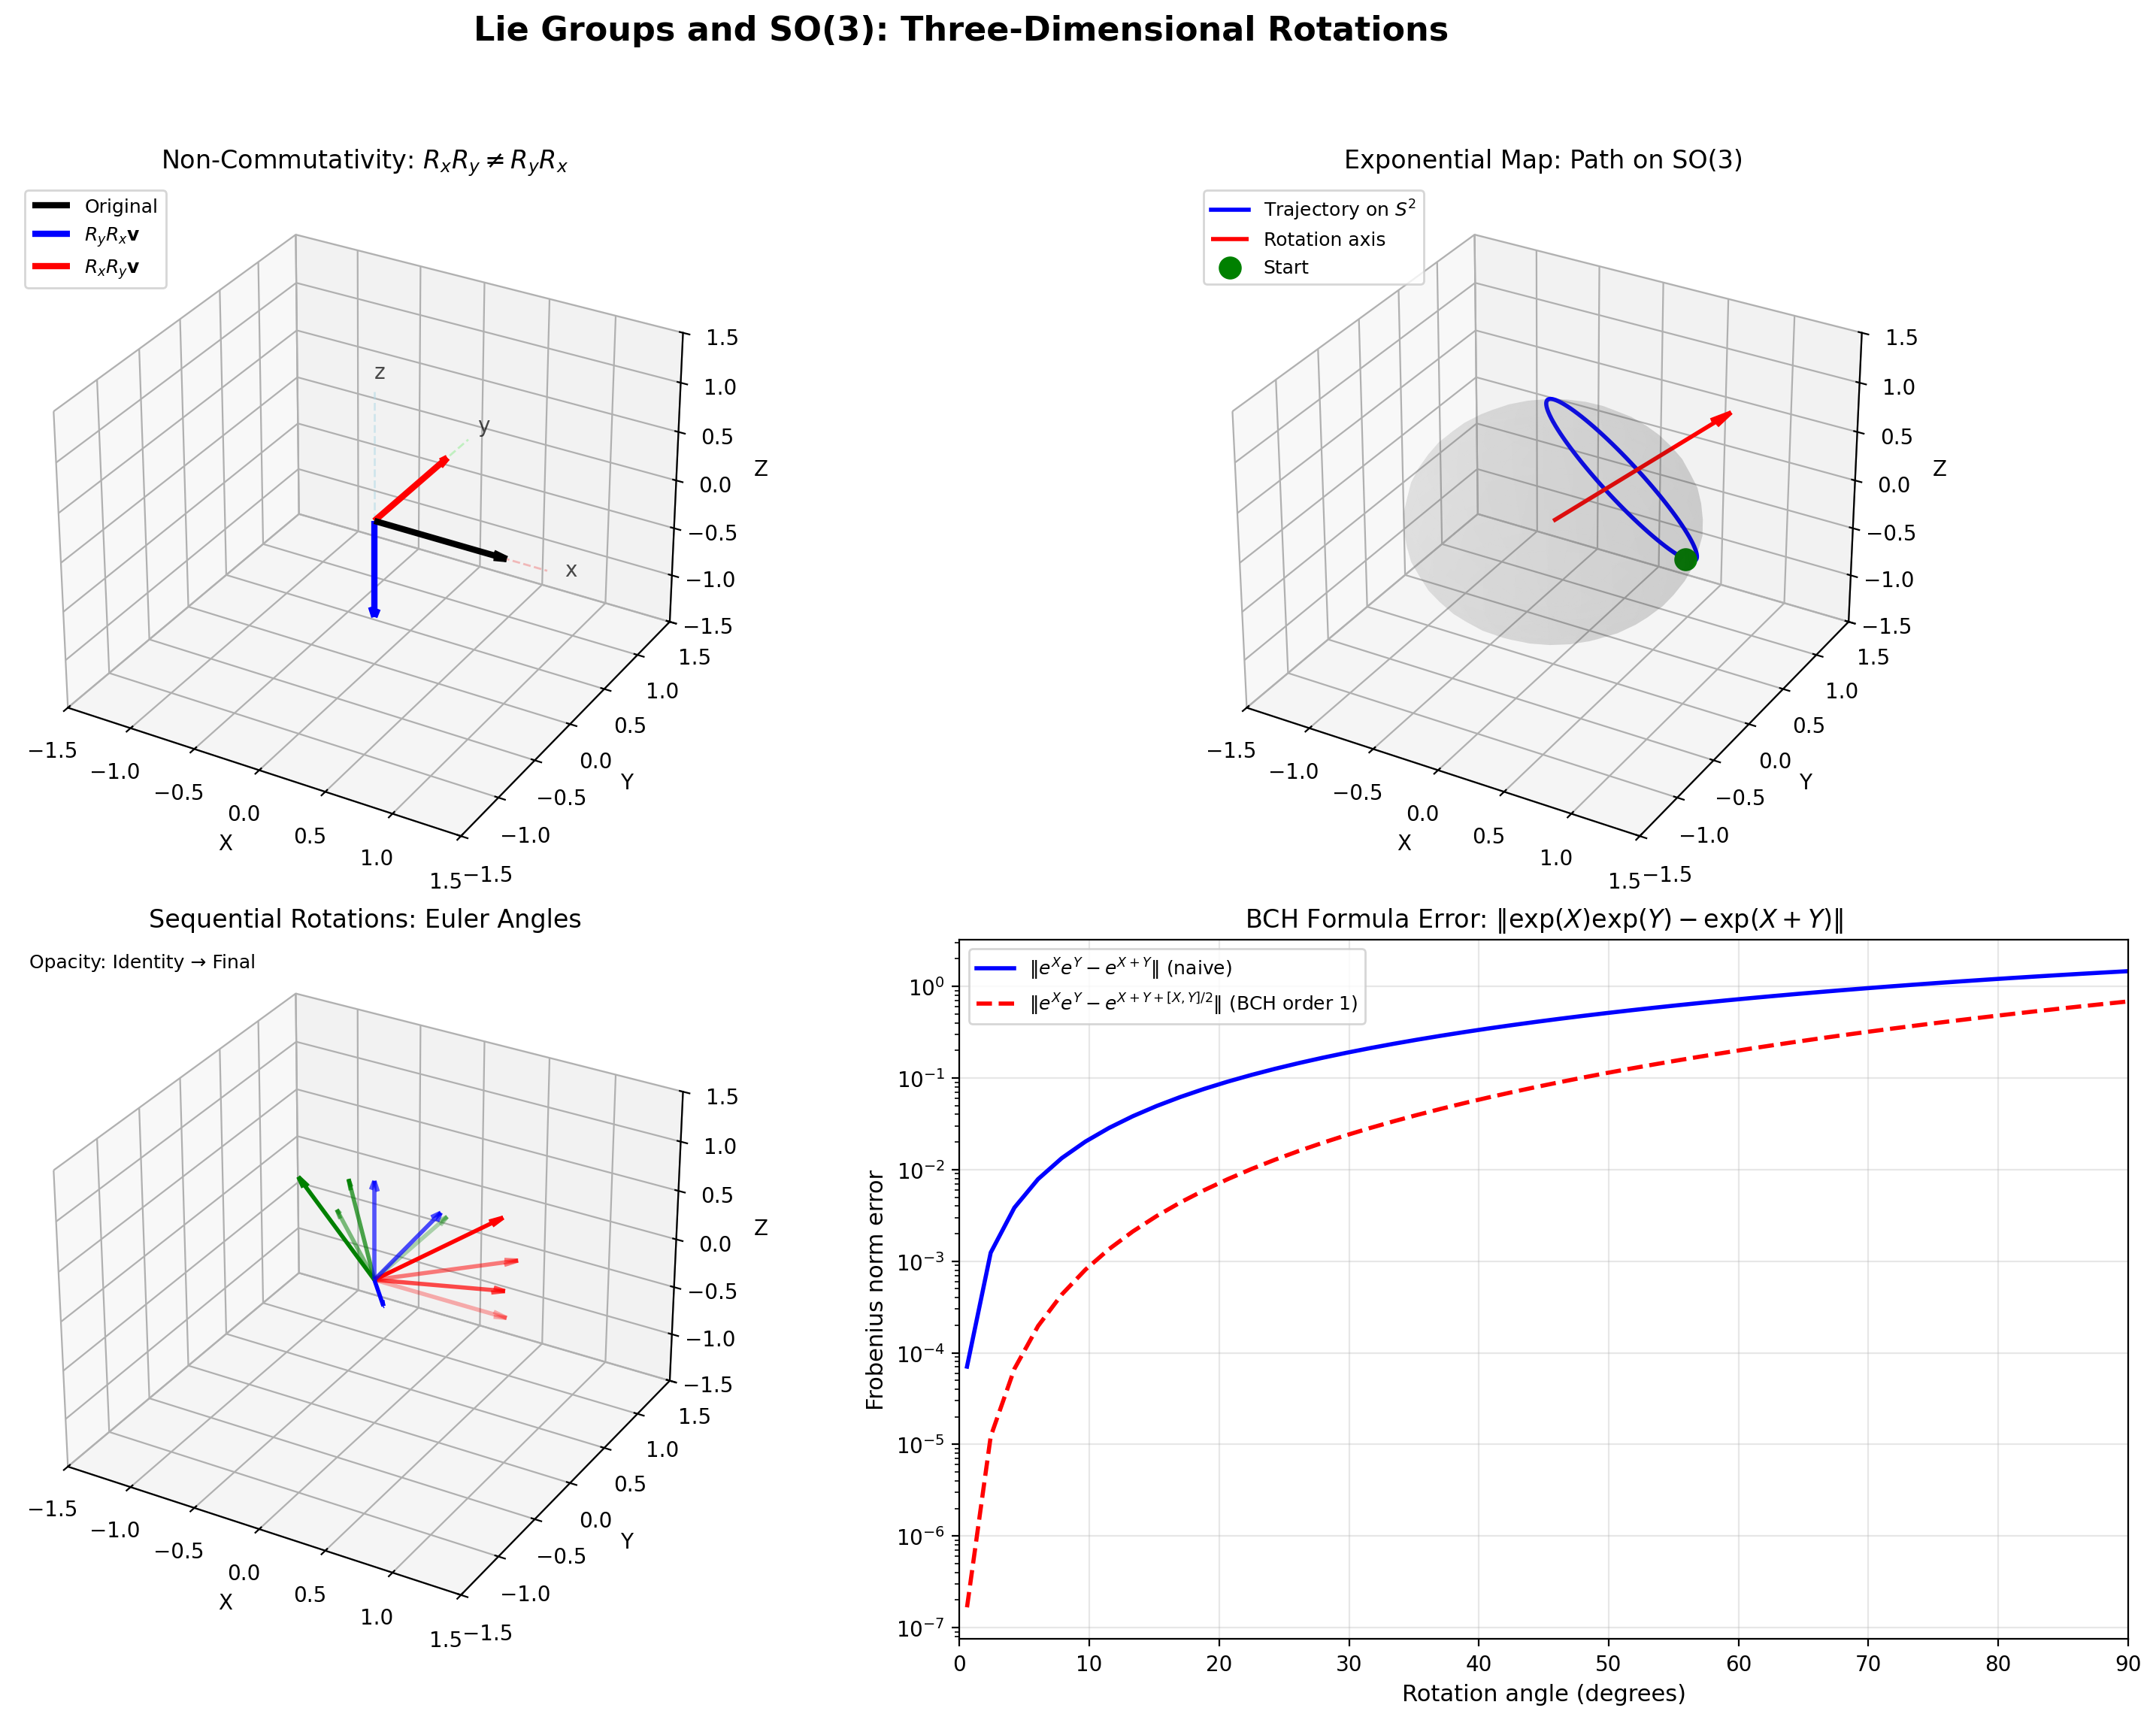


Plot saved to 'plot.png'


In [7]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Lie Groups and SO(3): Three-Dimensional Rotations', fontsize=16, fontweight='bold')

# ============================================================
# Plot 1: Non-commutativity of rotations
# ============================================================
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.set_title('Non-Commutativity: $R_x R_y \\neq R_y R_x$', fontsize=12)

# Define a test vector to rotate
v_original = np.array([1, 0, 0])

# 90-degree rotations
R_x_90 = rodrigues((np.pi/2) * np.array([1, 0, 0]))
R_y_90 = rodrigues((np.pi/2) * np.array([0, 1, 0]))

# Apply rotations in different orders
v_xy = R_y_90 @ R_x_90 @ v_original  # x first, then y
v_yx = R_x_90 @ R_y_90 @ v_original  # y first, then x

# Draw coordinate axes
for i, (color, label) in enumerate(zip(['lightcoral', 'lightgreen', 'lightblue'], ['x', 'y', 'z'])):
    direction = np.eye(3)[:, i] * 1.3
    ax1.plot([0, direction[0]], [0, direction[1]], [0, direction[2]], 
             color=color, linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(direction[0]*1.1, direction[1]*1.1, direction[2]*1.1, label, fontsize=10, alpha=0.7)

# Plot vectors
ax1.quiver(0, 0, 0, v_original[0], v_original[1], v_original[2], 
           color='black', arrow_length_ratio=0.1, linewidth=3, label='Original')
ax1.quiver(0, 0, 0, v_xy[0], v_xy[1], v_xy[2], 
           color='blue', arrow_length_ratio=0.1, linewidth=3, label='$R_y R_x \\mathbf{v}$')
ax1.quiver(0, 0, 0, v_yx[0], v_yx[1], v_yx[2], 
           color='red', arrow_length_ratio=0.1, linewidth=3, label='$R_x R_y \\mathbf{v}$')

ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1.5, 1.5])
ax1.set_zlim([-1.5, 1.5])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend(loc='upper left', fontsize=9)

# ============================================================
# Plot 2: Exponential map trajectory
# ============================================================
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.set_title('Exponential Map: Path on SO(3)', fontsize=12)

# Create trajectory by varying the angle
axis = np.array([1, 1, 1]) / np.sqrt(3)  # Normalized axis
angles = np.linspace(0, 2*np.pi, 100)

# Track how a point moves under rotation
initial_point = np.array([1, 0, 0])
trajectory = np.array([rodrigues(t * axis) @ initial_point for t in angles])

# Plot the trajectory
ax2.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
         'b-', linewidth=2, label='Trajectory on $S^2$')

# Plot unit sphere (wireframe)
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 20)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')

# Plot rotation axis
ax2.quiver(0, 0, 0, axis[0]*1.5, axis[1]*1.5, axis[2]*1.5, 
           color='red', arrow_length_ratio=0.1, linewidth=2, label='Rotation axis')

# Mark start and end points
ax2.scatter(*initial_point, color='green', s=100, label='Start', zorder=5)

ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1.5, 1.5])
ax2.set_zlim([-1.5, 1.5])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend(loc='upper left', fontsize=9)

# ============================================================
# Plot 3: Coordinate frame rotation sequence
# ============================================================
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.set_title('Sequential Rotations: Euler Angles', fontsize=12)

# Euler angles (Z-Y-X convention)
psi = np.pi/4    # Rotation about z
theta = np.pi/6  # Rotation about y
phi = np.pi/3    # Rotation about x

R_z = rodrigues(psi * np.array([0, 0, 1]))
R_y = rodrigues(theta * np.array([0, 1, 0]))
R_x = rodrigues(phi * np.array([1, 0, 0]))

# Sequential composition
frames = [
    (np.eye(3), 'Identity', 0.3),
    (R_z, f'After $R_z({np.degrees(psi):.0f}°)$', 0.5),
    (R_y @ R_z, f'After $R_y({np.degrees(theta):.0f}°)$', 0.7),
    (R_x @ R_y @ R_z, f'Final: $R_x R_y R_z$', 1.0)
]

for R, label, alpha in frames:
    draw_coordinate_frame(ax3, R, scale=1.0, alpha=alpha)

ax3.set_xlim([-1.5, 1.5])
ax3.set_ylim([-1.5, 1.5])
ax3.set_zlim([-1.5, 1.5])
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.text2D(0.02, 0.98, 'Opacity: Identity → Final', transform=ax3.transAxes, 
           fontsize=9, verticalalignment='top')

# ============================================================
# Plot 4: Baker-Campbell-Hausdorff illustration
# ============================================================
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('BCH Formula Error: $\\|\\exp(X)\\exp(Y) - \\exp(X+Y)\\|$', fontsize=12)

# For non-commuting elements, exp(X)exp(Y) ≠ exp(X+Y)
# The BCH formula gives the correction
angles = np.linspace(0.01, np.pi/2, 50)
errors_naive = []
errors_bch_first_order = []

for angle in angles:
    X = hat(angle * np.array([1, 0, 0]))
    Y = hat(angle * np.array([0, 1, 0]))
    
    # True product
    exp_X_exp_Y = expm(X) @ expm(Y)
    
    # Naive approximation (would be exact if X and Y commuted)
    exp_X_plus_Y = expm(X + Y)
    
    # First-order BCH correction: exp(X + Y + [X,Y]/2)
    bch_first = expm(X + Y + 0.5 * lie_bracket(X, Y))
    
    errors_naive.append(np.linalg.norm(exp_X_exp_Y - exp_X_plus_Y, 'fro'))
    errors_bch_first_order.append(np.linalg.norm(exp_X_exp_Y - bch_first, 'fro'))

ax4.semilogy(np.degrees(angles), errors_naive, 'b-', linewidth=2, 
             label='$\\|e^X e^Y - e^{X+Y}\\|$ (naive)')
ax4.semilogy(np.degrees(angles), errors_bch_first_order, 'r--', linewidth=2,
             label='$\\|e^X e^Y - e^{X+Y+[X,Y]/2}\\|$ (BCH order 1)')
ax4.set_xlabel('Rotation angle (degrees)', fontsize=11)
ax4.set_ylabel('Frobenius norm error', fontsize=11)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 90])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('lie_groups_so3_rotation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nPlot saved to 'plot.png'")

## 4. Advanced Topics

### 4.1 Quaternion Representation

Quaternions provide an alternative parameterization of $\mathrm{SO}(3)$ that avoids gimbal lock and is computationally efficient.

In [8]:
def axis_angle_to_quaternion(axis, angle):
    """
    Convert axis-angle to unit quaternion.
    
    A unit quaternion q = (w, x, y, z) represents a rotation by angle θ 
    about axis n as: q = (cos(θ/2), sin(θ/2)*n)
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)  # Normalize
    
    w = np.cos(angle / 2)
    xyz = np.sin(angle / 2) * axis
    
    return np.array([w, xyz[0], xyz[1], xyz[2]])

def quaternion_to_rotation_matrix(q):
    """
    Convert unit quaternion to rotation matrix.
    """
    q = q / np.linalg.norm(q)  # Ensure unit quaternion
    w, x, y, z = q
    
    R = np.array([
        [1 - 2*(y**2 + z**2), 2*(x*y - w*z), 2*(x*z + w*y)],
        [2*(x*y + w*z), 1 - 2*(x**2 + z**2), 2*(y*z - w*x)],
        [2*(x*z - w*y), 2*(y*z + w*x), 1 - 2*(x**2 + y**2)]
    ])
    return R

def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions (Hamilton product).
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

# Demonstrate quaternion representation
axis = np.array([1, 1, 1]) / np.sqrt(3)
angle = np.pi / 3

q = axis_angle_to_quaternion(axis, angle)
R_from_q = quaternion_to_rotation_matrix(q)
R_from_rodrigues = rodrigues(angle * axis)

print(f"Rotation: {np.degrees(angle):.1f}° about axis {axis}")
print(f"\nQuaternion q = (w, x, y, z):")
print(f"  {q}")
print(f"  |q| = {np.linalg.norm(q):.6f} (unit quaternion)")
print(f"\nRotation matrix from quaternion matches Rodrigues: {np.allclose(R_from_q, R_from_rodrigues)}")

# Demonstrate quaternion multiplication = rotation composition
q1 = axis_angle_to_quaternion([1, 0, 0], np.pi/4)
q2 = axis_angle_to_quaternion([0, 1, 0], np.pi/4)

q_product = quaternion_multiply(q2, q1)  # Note: q2 * q1 for R2 @ R1
R_product = quaternion_to_rotation_matrix(q_product)
R_direct = quaternion_to_rotation_matrix(q2) @ quaternion_to_rotation_matrix(q1)

print(f"\nQuaternion multiplication matches matrix multiplication: {np.allclose(R_product, R_direct)}")

Rotation: 60.0° about axis [0.57735027 0.57735027 0.57735027]

Quaternion q = (w, x, y, z):
  [0.8660254  0.28867513 0.28867513 0.28867513]
  |q| = 1.000000 (unit quaternion)

Rotation matrix from quaternion matches Rodrigues: True

Quaternion multiplication matches matrix multiplication: True


### 4.2 Geodesics on SO(3)

The geodesic (shortest path) between two rotation matrices $R_0$ and $R_1$ on $\mathrm{SO}(3)$ can be computed using the exponential and logarithm maps.

In [9]:
def geodesic_so3(R0, R1, t):
    """
    Compute the geodesic between R0 and R1 at parameter t ∈ [0, 1].
    
    R(t) = R0 * exp(t * log(R0^T R1))
    """
    # Relative rotation
    R_rel = R0.T @ R1
    
    # Logarithm to get the rotation vector
    omega = log_so3(R_rel)
    
    # Interpolated rotation
    R_t = R0 @ rodrigues(t * omega)
    return R_t

# Define start and end rotations
R0 = np.eye(3)
R1 = rodrigues(np.array([np.pi/2, np.pi/3, np.pi/4]))

# Sample the geodesic
t_values = np.linspace(0, 1, 10)

print("Geodesic interpolation from R0 to R1:")
print("="*50)

for t in [0, 0.25, 0.5, 0.75, 1.0]:
    R_t = geodesic_so3(R0, R1, t)
    omega_t = log_so3(R_t)
    angle_t = np.linalg.norm(omega_t)
    print(f"t = {t:.2f}: rotation angle = {np.degrees(angle_t):.2f}°")

# Verify it's a valid rotation at all points
print(f"\nAll interpolated matrices are in SO(3): ", end='')
all_valid = True
for t in np.linspace(0, 1, 100):
    R_t = geodesic_so3(R0, R1, t)
    if not (np.allclose(R_t @ R_t.T, np.eye(3)) and np.isclose(np.linalg.det(R_t), 1)):
        all_valid = False
        break
print(all_valid)

Geodesic interpolation from R0 to R1:
t = 0.00: rotation angle = 0.00°
t = 0.25: rotation angle = 29.29°
t = 0.50: rotation angle = 58.58°
t = 0.75: rotation angle = 87.87°
t = 1.00: rotation angle = 117.15°

All interpolated matrices are in SO(3): True


## 5. Summary

In this notebook, we have explored the mathematical structure of $\mathrm{SO}(3)$, the Lie group of three-dimensional rotations:

1. **Definition**: $\mathrm{SO}(3)$ consists of orthogonal matrices with determinant +1

2. **Lie Algebra**: The associated Lie algebra $\mathfrak{so}(3)$ consists of skew-symmetric matrices, isomorphic to $\mathbb{R}^3$ via the hat map

3. **Exponential Map**: Rodrigues' formula provides a closed-form expression for the exponential map $\exp: \mathfrak{so}(3) \to \mathrm{SO}(3)$

4. **Non-Commutativity**: 3D rotations do not commute in general, encoded in the Lie bracket $[L_i, L_j] = \epsilon_{ijk}L_k$

5. **Alternative Representations**: Quaternions provide a singularity-free parameterization with efficient composition

6. **Geodesics**: The exponential and logarithm maps enable interpolation along geodesics on $\mathrm{SO}(3)$

These concepts are fundamental in robotics, computer graphics, aerospace engineering, and theoretical physics, wherever three-dimensional orientation and rotation must be precisely described and manipulated.